In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import math

In [27]:
class Timer:
    def __init__(self, msg='Time elapsed'):
        self.msg = msg
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        duration = self.end - self.start
        print(f'{self.msg}: {duration:.2f}s')#.format(self.end - self.start))

In [28]:
class Event:
    __slots__ = 't', 'x', 'y', 'p'
    def __init__(self, t, x, y, p):
        self.t = t
        self.x = x
        self.y = y
        self.p = p
    def __repr__(self):
        return f'Event(t={self.t:.3f}, x={self.x}, y={self.y}, p={self.p})'

In [37]:
with Timer('Loading'):
    path_to_events = 'data/boxes_6dof/events.zip'
    header = pd.read_csv(path_to_events, delim_whitespace=True, names=['width', 'height'],
                         dtype={'width': np.int, 'height': np.int}, nrows=1)
    width, height = header.values[0]
    print(f'width, height: {width}, {height}')
    event_pd = pd.read_csv(path_to_events, delim_whitespace=True, header=None,
                              names=['t', 'x', 'y', 'p'],
                              dtype={'t': np.float64, 'x': np.int16, 'y': np.int16, 'p': np.int8},
                              engine='c',
                              skiprows=1, memory_map=True)

width, height: 240, 180
Loading: 0.97s


In [30]:
with Timer('Converting'):
    event_list = []
    for event in event_pd.values:
        t, x, y, p = event
        event_list.append(Event(t, int(x), int(y), -1 if p < 0.5 else 1))

Converting: 8.24s


In [48]:
with Timer('Reconstruction'):
    fixed_beta = True
    cutoff_frequency = 1  # rad/s
    time_surface = np.zeros((height, width), dtype=np.float32)
    image_state = np.zeros((height, width), dtype=np.float32)
    for e in event_list[:1000000]:
        if fixed_beta:
            beta = 0.9
        else:  # as described in Scheerlinck'18 (slower)
            beta = math.exp(-cutoff_frequency * (e.t - time_surface[e.y, e.x]))
            time_surface[e.y, e.x] = e.t
        image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p


Reconstruction: 2.58s


In [32]:
# with Timer('Reconstruction from numpy'):
#     image_state = np.zeros((height, width), dtype=np.float32)
#     for e in event_pd.values:
#         image_state[int(e[2]), int(e[1])] = 0.9*image_state[int(e[2]), int(e[1])] + e[3]

Reconstruction from numpy: 11.63s


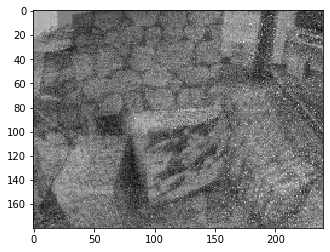

In [49]:
plt.imshow(image_state, cmap='gray')
plt.show()